In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Survey data

In [76]:
column_map = {
    'Q150r':'sexuality', 'NQ149r': 'religion', 'NQ155r':'uk_citizen', 'NQ147r': 'ethnicity', 'Q136r':'age', 'XQ135r':'gender'
}

effectiveness_questions = ['Q79I', 'Q79B', 'Q79D', 'Q79E']
fairness_engagement_questions = ['Q62B', 'Q62C', 'A121']
accountability_questions = ['NQ135BH']
confidence_questions = ['Q65', 'Q21', 'Q131']

cols = ['MONTH', 'C2'] + ['Q150r', 'NQ149r', 'NQ155r', 'NQ147r', 'Q136r', 'XQ135r'] + effectiveness_questions + fairness_engagement_questions + accountability_questions + confidence_questions 

age_mapping = {'16-24': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65 or over': 6}


In [77]:
files = [
    "data/pas_data_ward_level/PAS_ward_level_FY_15_17.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_17_18.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_18_19.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_19_20.csv"
]

all_data = pd.DataFrame()

# survey_columns = [
#     'MONTH', 'C2',
#     'Q79I', 'Q79B', 'Q79D', 'Q79E',  # Effectiveness
#     'Q62B', 'Q62C', 'A121',  # Fairness and engagement
#     'NQ135BH',  # Accountability
#     'Q65', 'Q21', 'Q131'  # Confidence
# ]

dataframes = []
for file in files:
    try:

        df = pd.read_csv(file)
        
        cols_to_select = [col for col in cols if col in df.columns]
        selected_df = df[cols_to_select]
        
        dataframes.append(selected_df)
        print(f"Loaded {file} with selected columns.")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Combine all the dataframes
surveys_df = pd.concat(dataframes, ignore_index=True)

Loaded data/pas_data_ward_level/PAS_ward_level_FY_15_17.csv with selected columns.
Loaded data/pas_data_ward_level/PAS_ward_level_FY_17_18.csv with selected columns.
Loaded data/pas_data_ward_level/PAS_ward_level_FY_18_19.csv with selected columns.
Loaded data/pas_data_ward_level/PAS_ward_level_FY_19_20.csv with selected columns.


In [78]:
surveys_demographics = surveys_df[cols]

### Encode demographic data

In [79]:
surveys_demographics.columns = [column_map[x] if x in column_map.keys() else x for x in surveys_demographics.columns]

surveys_demographics['is_hetero'] = (surveys_demographics['sexuality'] == 'Heterosexual').astype(int)
surveys_demographics['is_uk'] = (surveys_demographics['uk_citizen'] == 'UK').astype(int)
surveys_demographics = pd.get_dummies(surveys_demographics, columns=['religion'], drop_first=True)
surveys_demographics = pd.get_dummies(surveys_demographics, columns=['ethnicity'], drop_first=True)
surveys_demographics = pd.get_dummies(surveys_demographics, columns=['gender'], drop_first=True)
surveys_demographics['age_range'] = surveys_demographics['age'].map(age_mapping)

In [80]:
surveys_demographics['uk_citizen'].value_counts()

uk_citizen
UK        35941
Non-UK    27013
Name: count, dtype: int64

In [81]:
column_map = {
    'Q150r':'sexuality', 'NQ149r': 'religion', 'NQ155r':'uk_citizen', 'NQ147r': 'ethnicity', 'Q136r':'age', 'XQ135r':'gender'
}

In [82]:
label_to_value_map = {
    '1 Not at all well': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7 Very well': 7,
    "Don't know": 97,
    'Refused': 98,
    'Not Asked': 99,

    'Strongly agree': 5,
    'Tend to agree': 4,
    'Neither agree nor disagree': 3,
    'Tend to disagree': 2,
    'Strongly disagree': 1,
    

    'Yes': 2,
    'No': 1,

    'Very confident': 4,
    'Fairly confident': 3,
    'Not very confident': 2,
    'Not at all confident': 1,

    'At least daily': 6,
    'At least weekly': 5,
    'At least fortnightly': 4,
    'At least monthly': 3,
    'Less often': 2,
    'Never': 1,

    'Very safe': 6,
    'Fairly safe': 5,
    'Fairly unsafe': 4,
    'Very unsafe': 2,
    '(spontaneous) Do not go out at all': 1,
    '(spontaneous) Do not go out alone': 3,

    'Very well informed': 3,
    'Fairly well informed': 2,
    'Not at all informed': 1
}

def label_to_value(label):
    return label_to_value_map.get(label, label)

In [83]:
questions = effectiveness_questions + fairness_engagement_questions + accountability_questions + confidence_questions

surveys_demographics[questions] = surveys_demographics[questions].applymap(label_to_value)


In [84]:
import seaborn as sns
import numpy as np
surveys_demographics.replace([97, 98, 99], np.nan, inplace=True)
# sns.heatmap(mock.isna())
# print(mock.dropna().shape)
surveys_demographics.dropna(inplace=True)

In [85]:
toselect = ['MONTH', 'C2', 'Q79I',
 'Q79B',
 'Q79D',
 'Q79E',
 'Q62B',
 'Q62C',
 'A121',
 'NQ135BH',
 'Q65',
 'Q21',
 'Q131',
 'is_hetero',
 'is_uk',
 'religion_Hindu',
 'religion_Muslim',
 'religion_No religion',
 'religion_Other religion',
 'ethnicity_Black',
 'ethnicity_Mixed',
 'ethnicity_Other',
 'ethnicity_White British',
 'ethnicity_White Other',
 'gender_Male',
 'gender_Other',
 'age_range']

surveys_demographics = surveys_demographics[toselect]


In [86]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.formula.api import ols

In [87]:
independent_vars = [
    'is_hetero', 'is_uk', 
    'Q("religion_Hindu")', 'Q("religion_Muslim")', 'Q("religion_No religion")', 'Q("religion_Other religion")',
    'Q("ethnicity_Black")', 'Q("ethnicity_Mixed")', 'Q("ethnicity_Other")', 'Q("ethnicity_White British")', 'Q("ethnicity_White Other")',
    'gender_Male', 'gender_Other', 
    'age_range'
]

formula_parts = ['Q131 ~ '] + independent_vars
formula = ' + '.join(formula_parts) + ' + ' + ' + '.join(f'{v1}:{v2}' for v1 in independent_vars for v2 in independent_vars if v1 != v2)
model = ols(formula, data=surveys_demographics).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Q131   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.523
Date:                Sat, 01 Jun 2024   Prob (F-statistic):           3.44e-37
Time:                        20:04:45   Log-Likelihood:                -28399.
No. Observations:               32197   AIC:                         5.696e+04
Df Residuals:                   32116   BIC:                         5.764e+04
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [88]:
def adjust_Q79I(row):
    adjustment = 0

    # Main effects
    if row['ethnicity_White British'] == 1:
        adjustment += 11.9952

    # Interaction effects
    if row['is_uk'] == 1 and row['ethnicity_Black'] == 1:
        adjustment += -7.9211
    if row['is_uk'] == 1 and row['ethnicity_White British'] == 1:
        adjustment += -11.5516
    if row['is_hetero'] == 1 and row['gender_Other'] == 1:
        adjustment += 102.0781
    if row['religion_Muslim'] == 1 and row['gender_Other'] == 1:
        adjustment += -3.919e-13  # This is effectively zero and can be ignored
    if row['religion_No religion'] == 1 and row['ethnicity_Other'] == 1:
        adjustment += 7.7939
    if row['religion_Other religion'] == 1 and row['ethnicity_Other'] == 1:
        adjustment += 11.9128
    if row['religion_Other religion'] == 1 and row['gender_Male'] == 1:
        adjustment += 4.2869

    # Apply the adjustment to the original Q79I response
    adjusted_response = row['Q79I'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q79I'] = surveys_demographics.apply(adjust_Q79I, axis=1)

In [89]:
def adjustQ79B(row):
    adjustment = 0

    # Main effects
    if row['is_uk'] == 1:
        adjustment += -0.4738
    if row['ethnicity_Black'] == 1:
        adjustment += -0.5863
    if row['gender_Other'] == 1:
        adjustment += -3.9287

    # Interaction effects
    if row['is_hetero'] == 1 and row['ethnicity_White British'] == 1:
        adjustment += -0.2297
    if row['is_uk'] == 1 and row['ethnicity_Black'] == 1:
        adjustment += -0.1465
    if row['is_uk'] == 1 and row['ethnicity_White British'] == 1:
        adjustment += 0.1248
    if row['religion_Muslim'] == 1 and row['ethnicity_Black'] == 1:
        adjustment += 0.2666
    if row['religion_Muslim'] == 1 and row['ethnicity_Mixed'] == 1:
        adjustment += 0.4384
    if row['religion_Muslim'] == 1 and row['ethnicity_Other'] == 1:
        adjustment += 0.1868
    if row['religion_Muslim'] == 1 and row['gender_Other'] == 1:
        adjustment += -1.322e-14  # This is effectively zero and can be ignored
    if row['religion_No religion'] == 1 and row['ethnicity_Black'] == 1:
        adjustment += 0.1846
    if row['religion_Other religion'] == 1 and row['ethnicity_Mixed'] == 1:
        adjustment += 0.4532
    if row['gender_Other'] == 1 and row['age_range'] != None:
        adjustment += 0.8285 * row['age_range']  # assuming age_range is scaled appropriately

    # Apply the adjustment to the original Q79B response
    adjusted_response = row['Q79B'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q79B'] = surveys_demographics.apply(adjustQ79B, axis=1)

In [90]:
def apply_Q79D(row):
    adjustment = 0

    # Main effects
    if row['is_uk']:
        adjustment += -0.5579
    if row['ethnicity_Black']:
        adjustment += -0.6811
    if row['ethnicity_White British']:
        adjustment += -0.3519
    if row['ethnicity_White Other']:
        adjustment += -0.2897
    if row['age_range'] is not None:
        adjustment += -0.0715 * row['age_range']

    # Interaction effects
    if row['is_hetero'] and row['ethnicity_Mixed']:
        adjustment += -0.3923
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.3674
    if row['is_uk'] and row['gender_Male']:
        adjustment += 0.0763
    if row['religion_Muslim'] and row['ethnicity_Black']:
        adjustment += 0.2895
    if row['religion_Muslim'] and row['ethnicity_Mixed']:
        adjustment += 0.3117
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.5389
    if row['religion_Other religion'] and row['ethnicity_Mixed']:
        adjustment += 0.4505

    # Apply the adjustment to the original Q79D response
    adjusted_response = row['Q79D'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q79D'] = surveys_demographics.apply(apply_Q79D, axis=1)


In [91]:
def apply_Q79E(row):
    adjustment = 0

    # Main effects
    if row['is_uk']:
        adjustment += -0.6151
    if row['ethnicity_Black']:
        adjustment += -0.8268
    if row['ethnicity_White British']:
        adjustment += -0.3697
    if row['ethnicity_White Other']:
        adjustment += -0.2511
    if row['age_range'] is not None:
        adjustment += -0.0896 * row['age_range']

    # Interaction effects
    if row['is_hetero'] and row['ethnicity_Black']:
        adjustment += 0.2552
    if row['is_hetero'] and row['gender_Other']:
        adjustment += 3.4662
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.4410
    if row['religion_Hindu'] and row['religion_Other religion']:
        adjustment += 1.366e-14
    if row['religion_Muslim'] and row['ethnicity_Black']:
        adjustment += 0.3045
    if row['religion_Muslim'] and row['ethnicity_Mixed']:
        adjustment += 0.3155
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.4747
    if row['ethnicity_Mixed'] and row['gender_Other']:
        adjustment += 4.9951

    # Apply the adjustment to the original Q79E response
    adjusted_response = row['Q79E'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q79E'] = surveys_demographics.apply(apply_Q79E, axis=1)

In [92]:
def apply_Q62B(row):
    adjustment = 0

    # Main effects
    if row['is_uk']:
        adjustment += -0.2783
    if row['ethnicity_Black']:
        adjustment += -0.2289

    # Interaction effects
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.1994
    if row['religion_Hindu'] and row['ethnicity_Other']:
        adjustment += -0.3091
    if row['religion_Muslim'] and row['ethnicity_Mixed']:
        adjustment += 0.1767
    if row['religion_Muslim'] and row['age_range'] is not None:
        adjustment += 0.0259 * row['age_range']
    if row['religion_No religion'] and row['age_range'] is not None:
        adjustment += -0.0345 * row['age_range']
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.1751
    if row['religion_Other religion'] and row['ethnicity_Mixed']:
        adjustment += 0.2160
    if row['religion_Other religion'] and row['gender_Other']:
        adjustment += -5.14e-16
    if row['gender_Male'] and row['age_range'] is not None:
        adjustment += -0.0091 * row['age_range']

    # Apply the adjustment to the original Q62B response
    adjusted_response = row['Q62B'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q62B'] = surveys_demographics.apply(apply_Q62B, axis=1)


In [93]:
def apply_Q62C(row):
    adjustment = 0

    # Main effects
    if row['is_hetero']:
        adjustment += 0.2519
    if row['is_uk']:
        adjustment += -0.4766
    if row['ethnicity_Black']:
        adjustment += -0.3972

    # Interaction effects
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.3184
    if row['is_uk'] and row['gender_Male']:
        adjustment += 0.0930
    if row['is_uk'] and row['age_range'] is not None:
        adjustment += 0.0263 * row['age_range']
    if row['religion_Muslim'] and row['ethnicity_Black']:
        adjustment += 0.1593
    if row['religion_Muslim'] and row['gender_Male']:
        adjustment += -0.0897
    if row['religion_Muslim'] and row['age_range'] is not None:
        adjustment += 0.0247 * row['age_range']
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.5451
    if row['religion_Other religion'] and row['ethnicity_White British']:
        adjustment += -0.2072
    if row['religion_No religion'] and row['age_range'] is not None:
        adjustment += -0.0391 * row['age_range']
    if row['gender_Male'] and row['age_range'] is not None:
        adjustment += -0.0122 * row['age_range']
    if row['ethnicity_White Other'] and row['gender_Other']:
        adjustment += -2.1980

    # Apply the adjustment to the original Q62C response
    adjusted_response = row['Q62C'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q62C'] = surveys_demographics.apply(apply_Q62C, axis=1)


In [94]:
def apply_A121(row):
    adjustment = 0

    # Main effects
    if row['is_hetero']:
        adjustment += 0.2989
    if row['is_uk']:
        adjustment += -0.3404
    if row['ethnicity_Black']:
        adjustment += -0.3090
    if row['gender_Other']:
        adjustment += -1.9573
    if row['religion_Muslim']:
        adjustment += 0.2123

    # Interaction effects
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.1971
    if row['is_uk'] and row['gender_Male']:
        adjustment += 0.0648
    if row['is_uk'] and row['age_range'] is not None:
        adjustment += 0.0302 * row['age_range']
    if row['is_hetero'] and row['gender_Male']:
        adjustment += -0.0687
    if row['religion_Muslim'] and row['ethnicity_Black']:
        adjustment += 0.1214
    if row['religion_Muslim'] and row['ethnicity_White British']:
        adjustment += -0.1770
    if row['religion_Muslim'] and row['gender_Male']:
        adjustment += -0.0604
    if row['religion_No religion'] and row['ethnicity_White British']:
        adjustment += -0.1121
    if row['religion_No religion'] and row['ethnicity_White Other']:
        adjustment += -0.1506
    if row['religion_No religion'] and row['age_range'] is not None:
        adjustment += -0.0221 * row['age_range']
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.2855
    if row['religion_Other religion'] and row['ethnicity_White British']:
        adjustment += -0.1774
    if row['religion_Other religion'] and row['ethnicity_White Other']:
        adjustment += -0.1291
    if row['gender_Male'] and row['age_range'] is not None:
        adjustment += 0.0118 * row['age_range']

    # Apply the adjustment to the original A121 response
    adjusted_response = row['A121'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_A121'] = surveys_demographics.apply(apply_A121, axis=1)



In [95]:
def apply_NQ135BH(row):
    adjustment = 0

    # Interaction effects with significant p-values
    if row['is_uk'] and row['ethnicity_Black']:
        adjustment += -7.8897
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += -11.7729
    if row['religion_Other religion'] and row['ethnicity_Other']:
        adjustment += 13.5283
    if row['religion_Muslim'] and row['age_range'] is not None:
        adjustment += -1.4949 * row['age_range']
    if row['religion_Other religion'] and row['gender_Other']:
        adjustment += -3.409e-14

    # Apply the adjustment to the original NQ135BH response
    adjusted_response = row['NQ135BH'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_NQ135BH'] = surveys_demographics.apply(apply_NQ135BH, axis=1)


In [96]:
surveys_demographics

,MONTH,C2,Q79I,Q79B,Q79D,Q79E,Q62B,Q62C,A121,NQ135BH,...,gender_Other,age_range,adjusted_Q79I,adjusted_Q79B,adjusted_Q79D,adjusted_Q79E,adjusted_Q62B,adjusted_Q62C,adjusted_A121,adjusted_NQ135BH
16048,64 (Jul 2016),Merton,5.0,6.0,4.0,4.0,5.0,5.0,2.0,5.0,...,False,4.0,5.4436,5.4213,3.2479,3.0978,4.8847,5.2431,2.3197,-6.7729
16049,64 (Jul 2016),Merton,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,...,False,2.0,5.4436,4.4213,4.3909,4.2770,4.8339,4.1367,4.0794,-7.7729
16050,64 (Jul 2016),Merton,3.0,5.0,5.0,3.0,2.0,1.0,3.0,4.0,...,False,4.0,3.4436,4.4213,4.2479,2.0978,1.8847,1.2431,3.3197,-7.7729
16053,64 (Jul 2016),Newham,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,...,False,1.0,-3.9211,2.7934,2.6895,2.7237,3.4928,3.4044,2.6797,-3.8897
16054,64 (Jul 2016),Newham,6.0,6.0,6.0,6.0,4.0,4.0,3.0,4.0,...,False,2.0,6.0000,6.0000,5.5673,5.5697,3.9818,4.2275,3.2538,4.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63657,108 (Mar 2020),Croydon,5.0,6.0,5.0,4.0,5.0,4.0,3.0,5.0,...,False,6.0,5.4436,5.4213,4.1049,2.9186,4.8665,4.2713,3.4037,-6.7729
63658,108 (Mar 2020),Croydon,7.0,7.0,7.0,5.0,5.0,5.0,3.0,5.0,...,False,6.0,7.0000,7.0000,6.2813,4.2113,4.9454,5.1787,3.3010,5.0000
63659,108 (Mar 2020),Croydon,3.0,5.0,5.0,3.0,4.0,4.0,3.0,5.0,...,False,1.0,-4.9211,3.7934,3.7658,1.7237,3.4837,3.4852,2.6876,-2.8897
63660,108 (Mar 2020),Barking and Dagenham,5.0,7.0,5.0,7.0,5.0,5.0,4.0,5.0,...,False,3.0,5.4436,6.4213,4.2431,6.1874,4.9211,5.1726,4.2462,-6.7729


In [97]:
def apply_Q65(row):
    base_value = 4.0303  # Intercept
    adjustment = 0

    # Apply adjustments
    adjustment += row.get('is_hetero', 0) * (-0.2577)
    adjustment += row.get('is_uk', 0) * (-0.6862)
    adjustment += row.get('ethnicity_White Other', 0) * (-0.3747)
    adjustment += row.get('gender_Male', 0) * 0.2339
    adjustment += row.get('age_range', 0) * (-0.1657)

    # Calculate final Q65 value
    final_q65 = base_value + adjustment
    return final_q65

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q65'] = surveys_demographics.apply(apply_Q65, axis=1)


In [98]:
def apply_Q21(row):
    base_value = 5.5248  # Intercept from the regression model
    adjustment = 0

    # Adjustments based on significant predictors using dummy variables
    adjustment += row.get('is_hetero', 0) * (-0.2826)
    adjustment += row.get('is_uk', 0) * (-0.3778)
    adjustment += row.get('religion_Muslim', 0) * (-0.6364)
    adjustment += row.get('religion_No religion', 0) * (-0.1791)
    adjustment += row.get('religion_Other religion', 0) * (-0.4015)
    adjustment += row.get('ethnicity_Black', 0) * (-0.3826)
    adjustment += row.get('ethnicity_Mixed', 0) * (-0.4245)
    adjustment += row.get('ethnicity_White Other', 0) * (-0.2529)
    adjustment += row.get('gender_Male', 0) * 0.1579

    # Calculate the final Q21 value
    final_q21 = base_value + adjustment
    return final_q21

       
surveys_demographics['adjusted_Q21'] = surveys_demographics.apply(apply_Q21, axis=1)


In [99]:
def apply_Q131(row):
    base_value = 1.4633  # Intercept
    adjustment = 0

    # Apply adjustments
    adjustment += row.get('is_uk', 0) * (-0.0959)
    adjustment += row.get('ethnicity_White Other', 0) * (-0.1221)

    # Calculate final Q131 value
    final_q131 = base_value + adjustment
    return final_q131

surveys_demographics['adjusted_Q131'] = surveys_demographics.apply(apply_Q131, axis=1)



In [100]:
surveys_demographics

,MONTH,C2,Q79I,Q79B,Q79D,Q79E,Q62B,Q62C,A121,NQ135BH,...,adjusted_Q79B,adjusted_Q79D,adjusted_Q79E,adjusted_Q62B,adjusted_Q62C,adjusted_A121,adjusted_NQ135BH,adjusted_Q65,adjusted_Q21,adjusted_Q131
16048,64 (Jul 2016),Merton,5.0,6.0,4.0,4.0,5.0,5.0,2.0,5.0,...,5.4213,3.2479,3.0978,4.8847,5.2431,2.3197,-6.7729,2.6575,5.0223,1.3674
16049,64 (Jul 2016),Merton,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,...,4.4213,4.3909,4.2770,4.8339,4.1367,4.0794,-7.7729,2.9889,4.8432,1.3674
16050,64 (Jul 2016),Merton,3.0,5.0,5.0,3.0,2.0,1.0,3.0,4.0,...,4.4213,4.2479,2.0978,1.8847,1.2431,3.3197,-7.7729,2.6575,5.0223,1.3674
16053,64 (Jul 2016),Newham,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,...,2.7934,2.6895,2.7237,3.4928,3.4044,2.6797,-3.8897,2.9207,4.4818,1.3674
16054,64 (Jul 2016),Newham,6.0,6.0,6.0,6.0,4.0,4.0,3.0,4.0,...,6.0000,5.5673,5.5697,3.9818,4.2275,3.2538,4.0000,3.3004,5.1472,1.3412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63657,108 (Mar 2020),Croydon,5.0,6.0,5.0,4.0,5.0,4.0,3.0,5.0,...,5.4213,4.1049,2.9186,4.8665,4.2713,3.4037,-6.7729,2.3261,5.0223,1.3674
63658,108 (Mar 2020),Croydon,7.0,7.0,7.0,5.0,5.0,5.0,3.0,5.0,...,7.0000,6.2813,4.2113,4.9454,5.1787,3.3010,5.0000,2.6376,5.1472,1.3412
63659,108 (Mar 2020),Croydon,3.0,5.0,5.0,3.0,4.0,4.0,3.0,5.0,...,3.7934,3.7658,1.7237,3.4837,3.4852,2.6876,-2.8897,3.1546,4.6397,1.3674
63660,108 (Mar 2020),Barking and Dagenham,5.0,7.0,5.0,7.0,5.0,5.0,4.0,5.0,...,6.4213,4.2431,6.1874,4.9211,5.1726,4.2462,-6.7729,2.5893,4.8644,1.3674


### Mappings

In [101]:
"""
    TODO:
    1. Apply column aggregation on 'wrong' dataframes
    2. Merge dataframes from all years
    3. Run statistical analysis on merged dataframe
"""

"\n    TODO:\n    1. Apply column aggregation on 'wrong' dataframes\n    2. Merge dataframes from all years\n    3. Run statistical analysis on merged dataframe\n"

In [102]:
from sklearn.preprocessing import MinMaxScaler

def scale_columns(dataframe, columns_to_scale):
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Apply the scaler to the selected columns and replace in dataframe
    dataframe[columns_to_scale] = scaler.fit_transform(dataframe[columns_to_scale])

    return dataframe

In [103]:
cols2 = ['adjusted_Q79I', 'adjusted_Q79B',
       'adjusted_Q79D', 'adjusted_Q79E', 'adjusted_Q62B', 'adjusted_Q62C',
       'adjusted_A121', 'adjusted_NQ135BH', 'adjusted_Q65', 'adjusted_Q21',
       'adjusted_Q131']

In [104]:
scaled_surveys_demographics = scale_columns(surveys_demographics, cols2)

In [105]:
grouped = scaled_surveys_demographics.groupby(['MONTH', 'C2']).median().reset_index()

effectiveness_questions = ['adjusted_Q79I', 'adjusted_Q79B',
       'adjusted_Q79D', 'adjusted_Q79E']
fairness_engagement_questions = ['adjusted_Q62B', 'adjusted_Q62C',
       'adjusted_A121']
accountability_questions = ['adjusted_NQ135BH']
confidence_questions = ['adjusted_Q65', 'adjusted_Q21',
       'adjusted_Q131']

# MAKE SURE MEAN IS CORRECT
grouped['Effectiveness'] = grouped[effectiveness_questions].mean(axis=1)
grouped['Fairness and Engagement'] = grouped[fairness_engagement_questions].mean(axis=1)
grouped['Accountability'] = grouped[accountability_questions].mean(axis=1)
grouped['Confidence Questions'] = grouped[confidence_questions].mean(axis=1)

# Calculate 'Trust' as the mean of the first three categories
grouped['Trust'] = grouped[['Effectiveness', 'Fairness and Engagement', 'Accountability']].mean(axis=1)

# Update 'Confidence' to be the mean of itself and 'Trust'
grouped['Confidence'] = grouped[['Confidence Questions', 'Trust']].mean(axis=1)

In [106]:
# Change the format of the month
grouped['Date'] = pd.to_datetime(grouped['MONTH'].str.extract(r'\((.*?)\)')[0], format='%b %Y')
grouped.sort_values('Date', inplace=True)
grouped['MONTH'] = grouped['Date'].dt.strftime('%b %Y')

In [107]:
final_grouped = grouped.groupby(['MONTH', 'C2']).mean().reset_index()

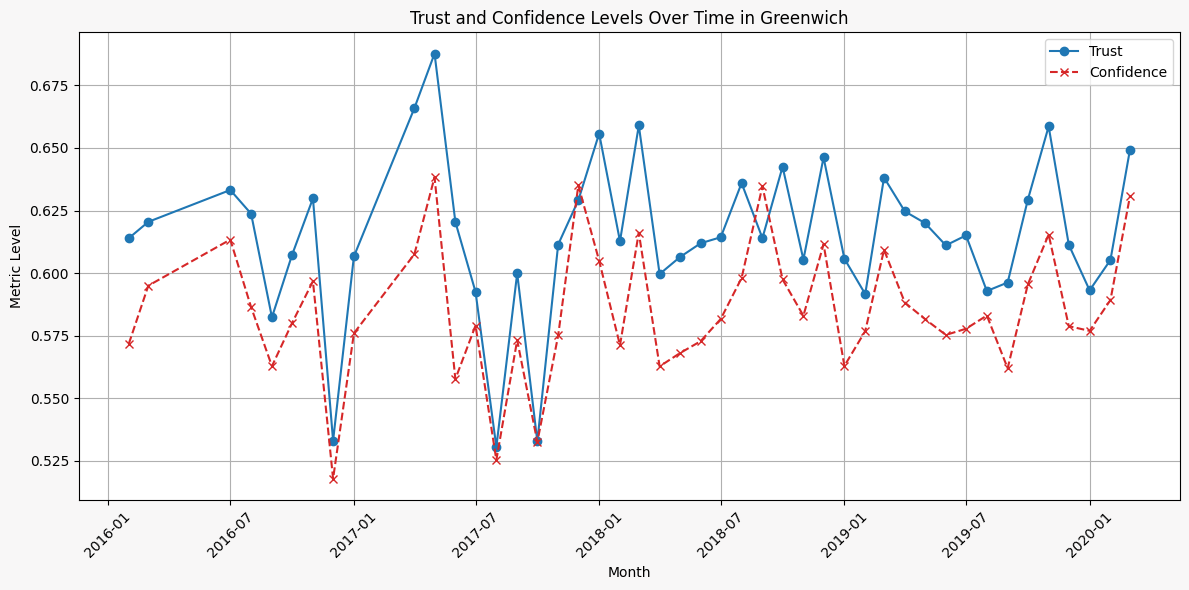

In [108]:
borough_data = final_grouped[final_grouped['C2'] == 'Westminster']
borough_data['MONTH'] = pd.to_datetime(borough_data['MONTH'], format='%b %Y')
borough_data.sort_values('MONTH', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(borough_data['MONTH'], borough_data['Trust'], color='tab:blue', marker='o', linestyle='-', label='Trust')
plt.plot(borough_data['MONTH'], borough_data['Confidence'], color='tab:red', marker='x', linestyle='--', label='Confidence')

plt.title('Trust and Confidence Levels Over Time in Greenwich')
plt.xlabel('Month')
plt.ylabel('Metric Level')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

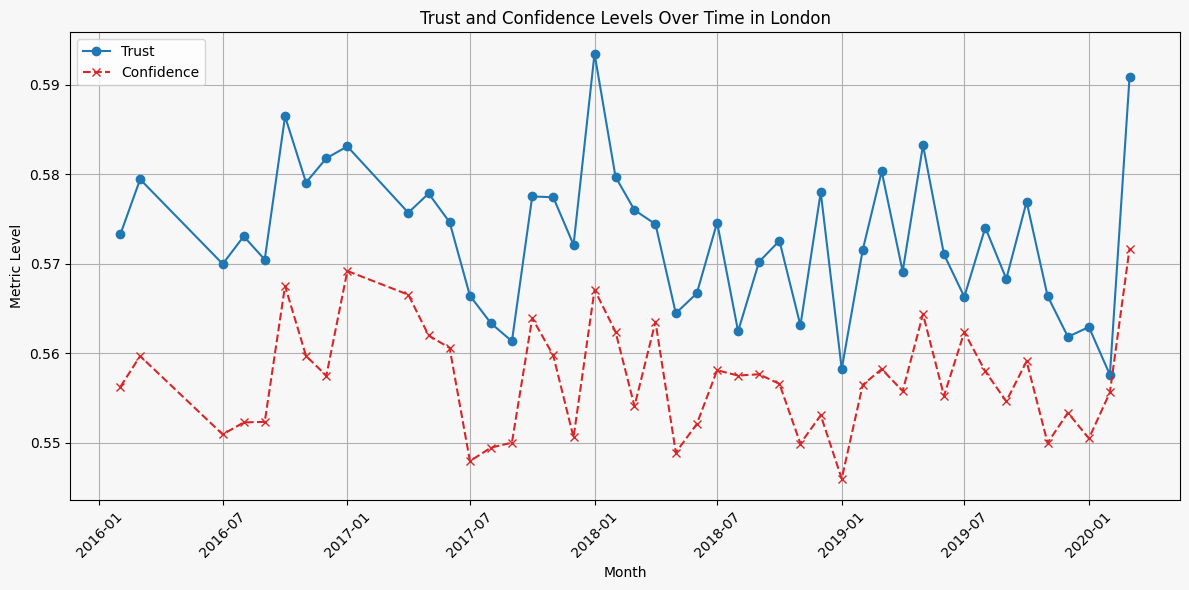

In [109]:
final_grouped['MONTH'] = pd.to_datetime(final_grouped['MONTH'], format='%b %Y')
final_grouped.sort_values('MONTH', inplace=True)

london_data = final_grouped.groupby('MONTH')[['Trust', 'Confidence']].mean().reset_index()

plt.rcParams['figure.facecolor'] = '#f8f7f7'

plt.figure(figsize=(12, 6), facecolor='#f8f7f7')
plt.plot(london_data['MONTH'], london_data['Trust'], color='tab:blue', marker='o', linestyle='-', label='Trust')
plt.plot(london_data['MONTH'], london_data['Confidence'], color='tab:red', marker='x', linestyle='--', label='Confidence')

plt.title('Trust and Confidence Levels Over Time in London')
plt.xlabel('Month')
plt.ylabel('Metric Level')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().set_facecolor('#f8f7f7')
plt.tight_layout()
plt.show()

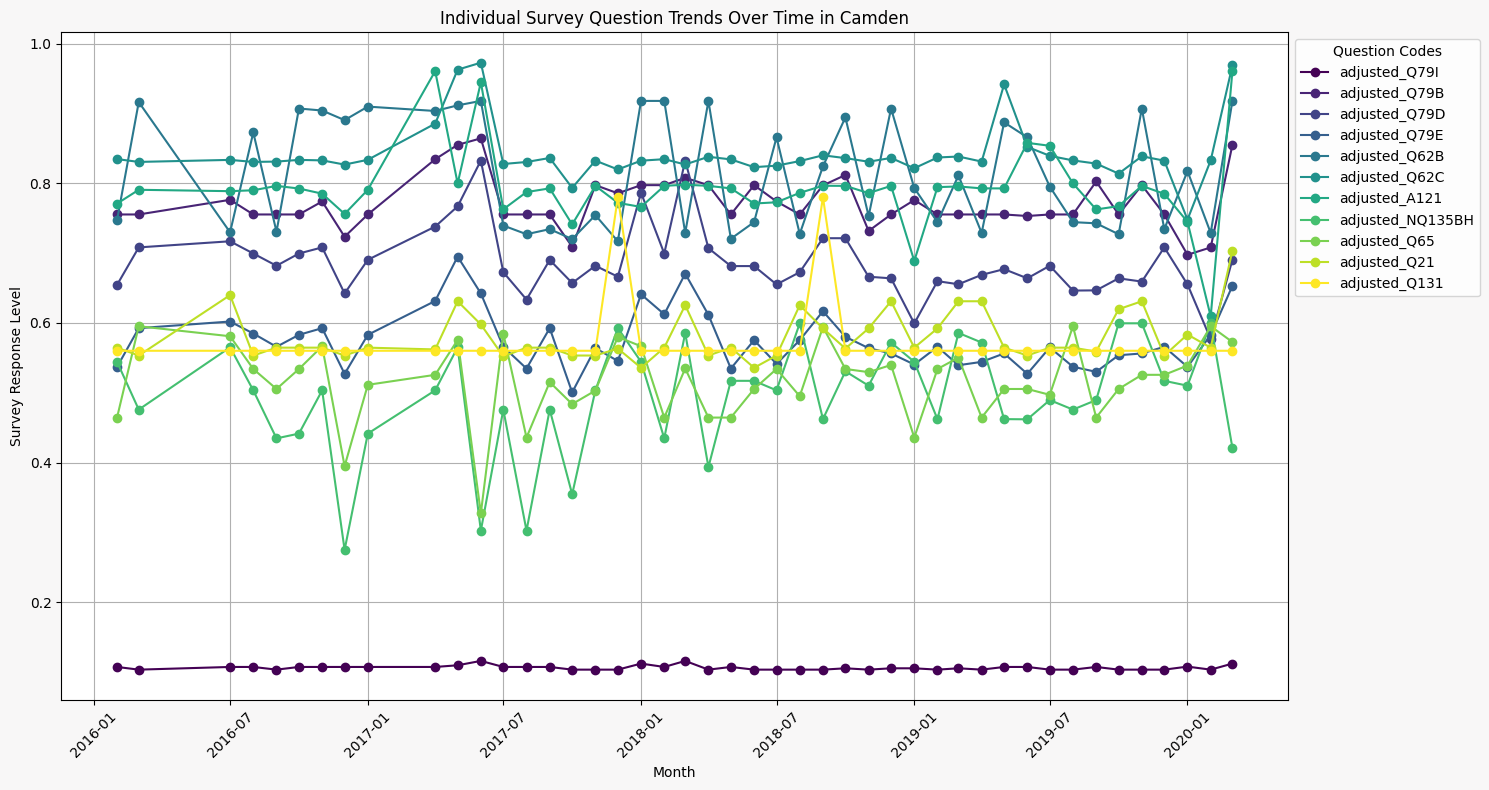

In [110]:
camden_data = final_grouped[final_grouped['C2'] == 'Westminster']
camden_data['MONTH'] = pd.to_datetime(camden_data['MONTH'], format='%b %Y')
camden_data = camden_data.sort_values('MONTH')

plt.figure(figsize=(15, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(cols2)))
for i, col in enumerate(cols2):
    plt.plot(camden_data['MONTH'], camden_data[col], label=col, color=colors[i], marker='o', linestyle='-')

plt.title('Individual Survey Question Trends Over Time in Camden')
plt.xlabel('Month')
plt.ylabel('Survey Response Level')
plt.legend(title='Question Codes', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

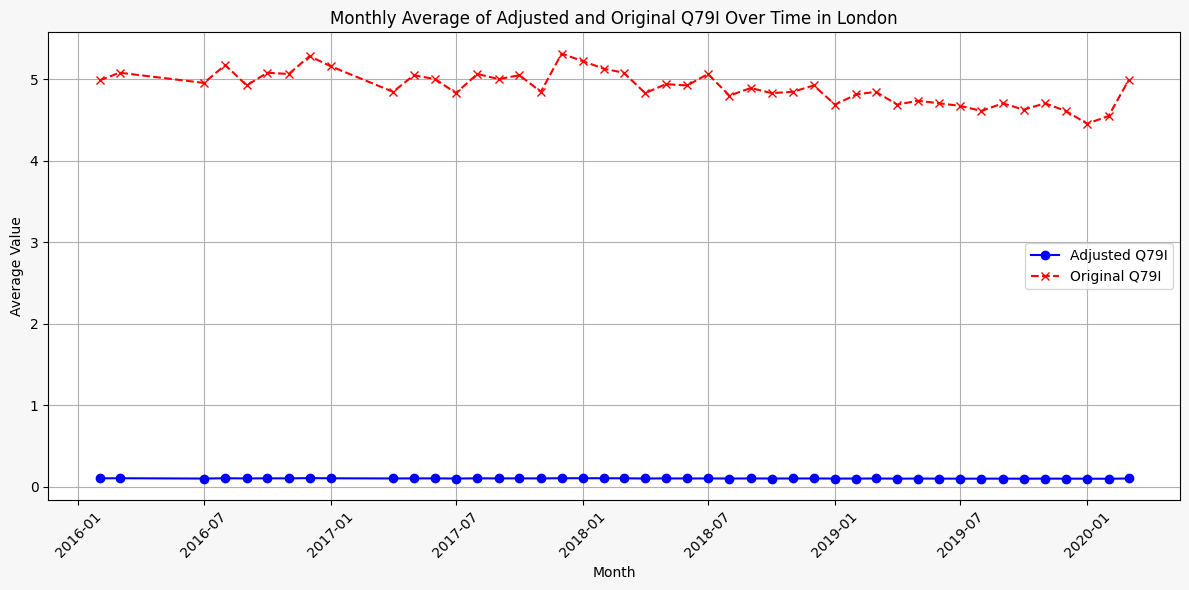

In [111]:
monthly_averages = final_grouped.groupby('MONTH').agg({
    'adjusted_Q79I': 'mean',
    'Q79I': 'mean'
}).reset_index()

monthly_averages['MONTH'] = pd.to_datetime(monthly_averages['MONTH'], format='%Y-%m')

plt.figure(figsize=(12, 6))
plt.plot(monthly_averages['MONTH'], monthly_averages['adjusted_Q79I'], label='Adjusted Q79I', marker='o', linestyle='-', color='blue')
plt.plot(monthly_averages['MONTH'], monthly_averages['Q79I'], label='Original Q79I', marker='x', linestyle='--', color='red')

plt.title('Monthly Average of Adjusted and Original Q79I Over Time in London')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

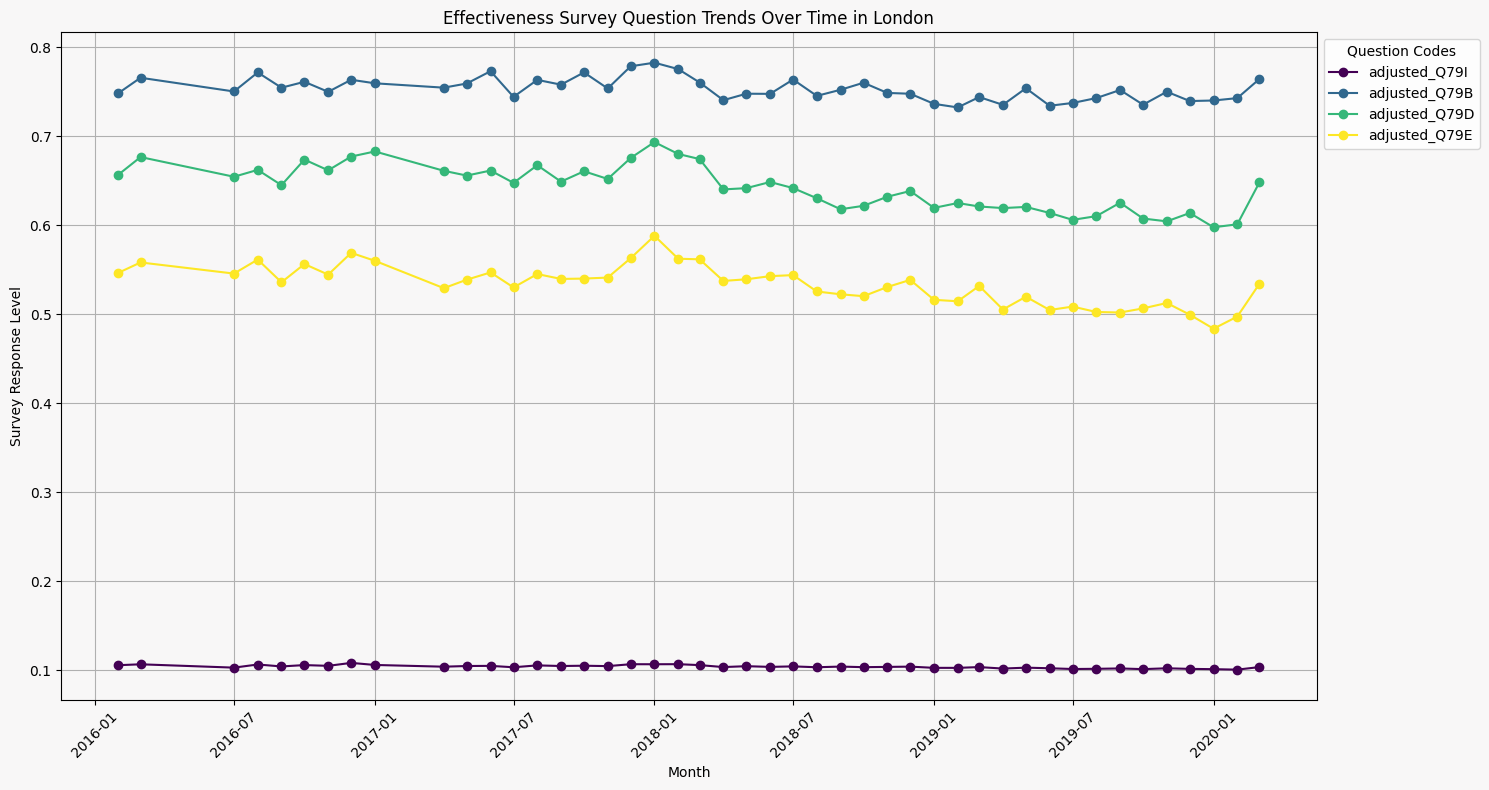

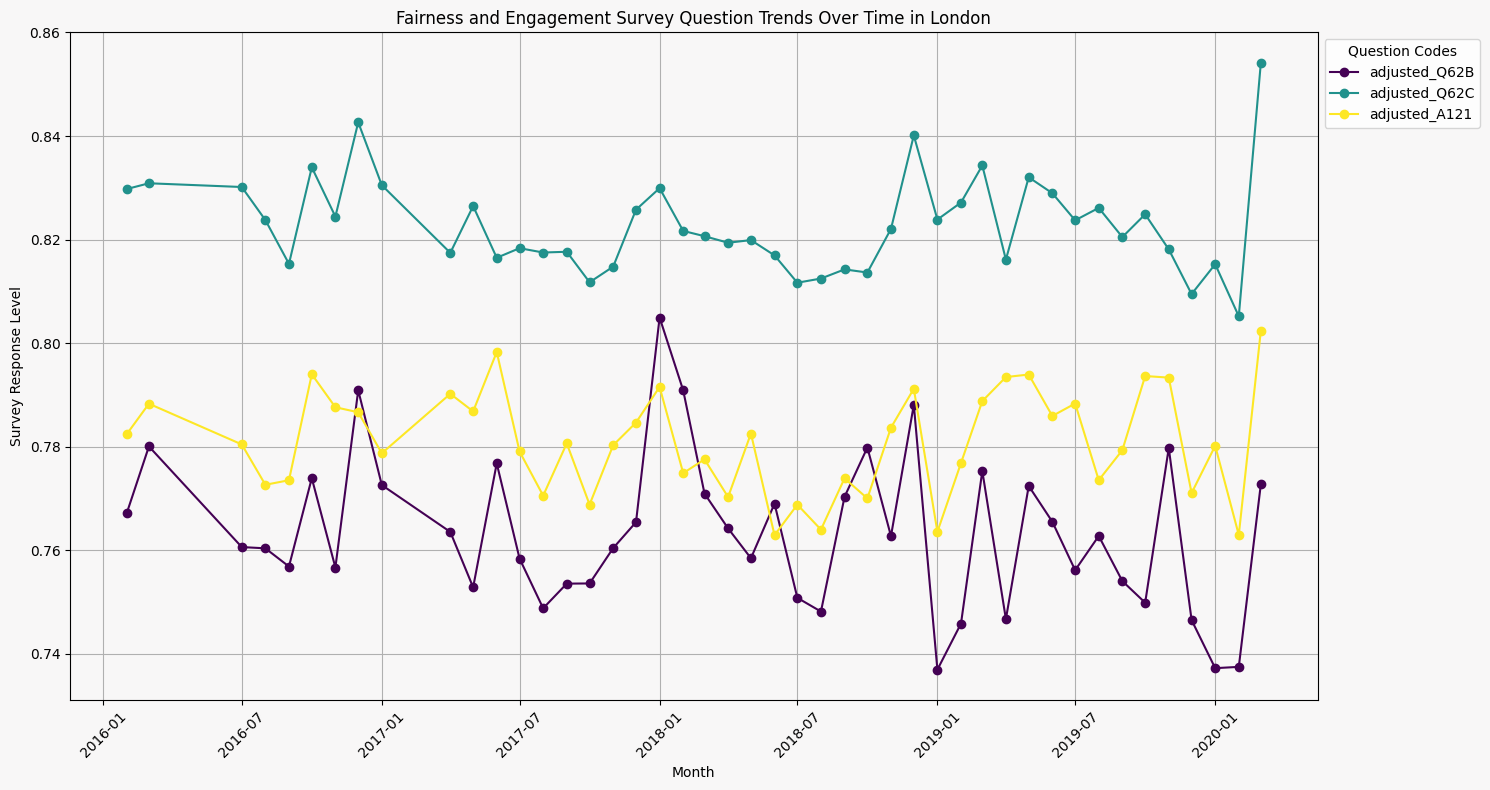

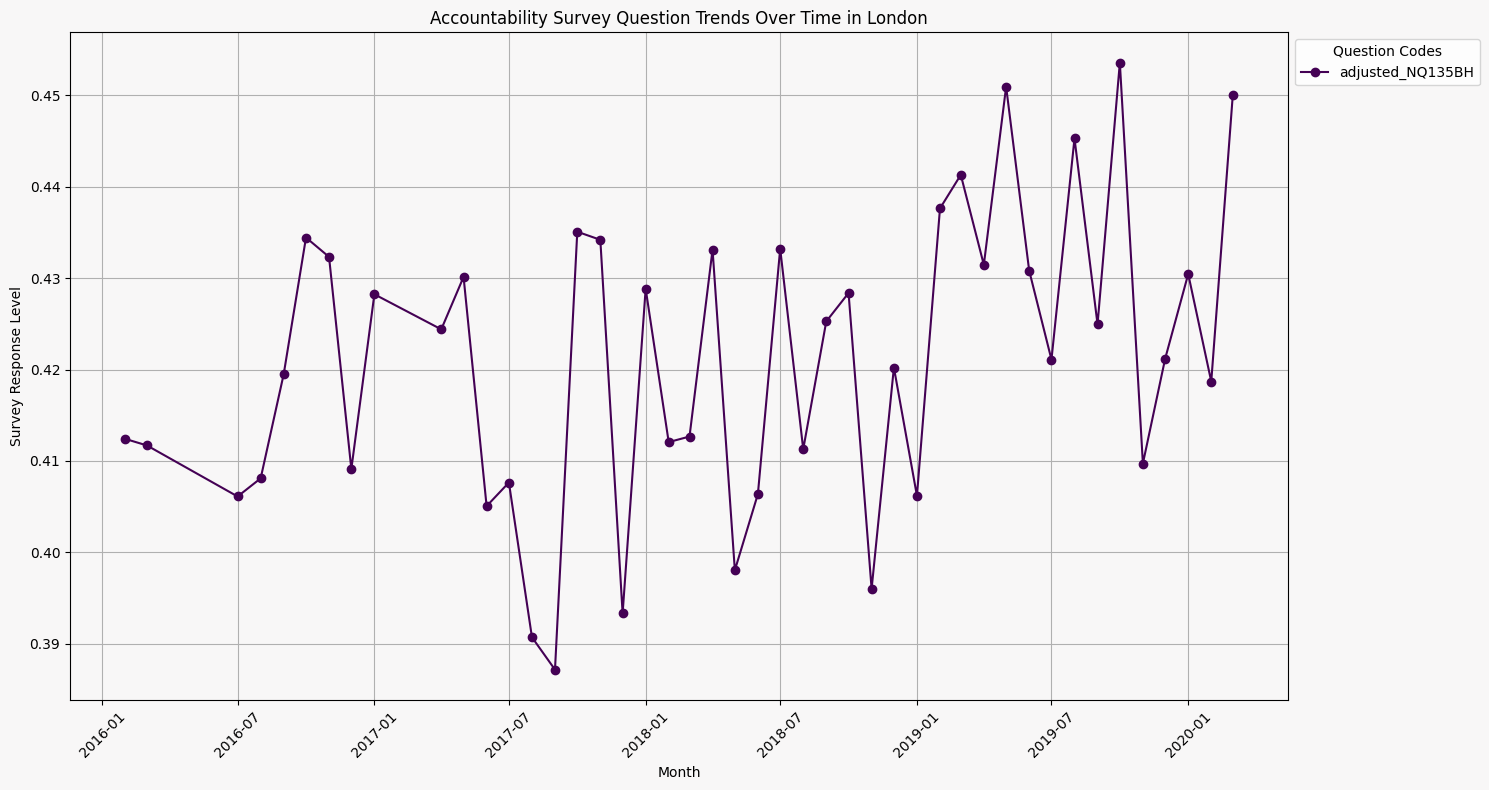

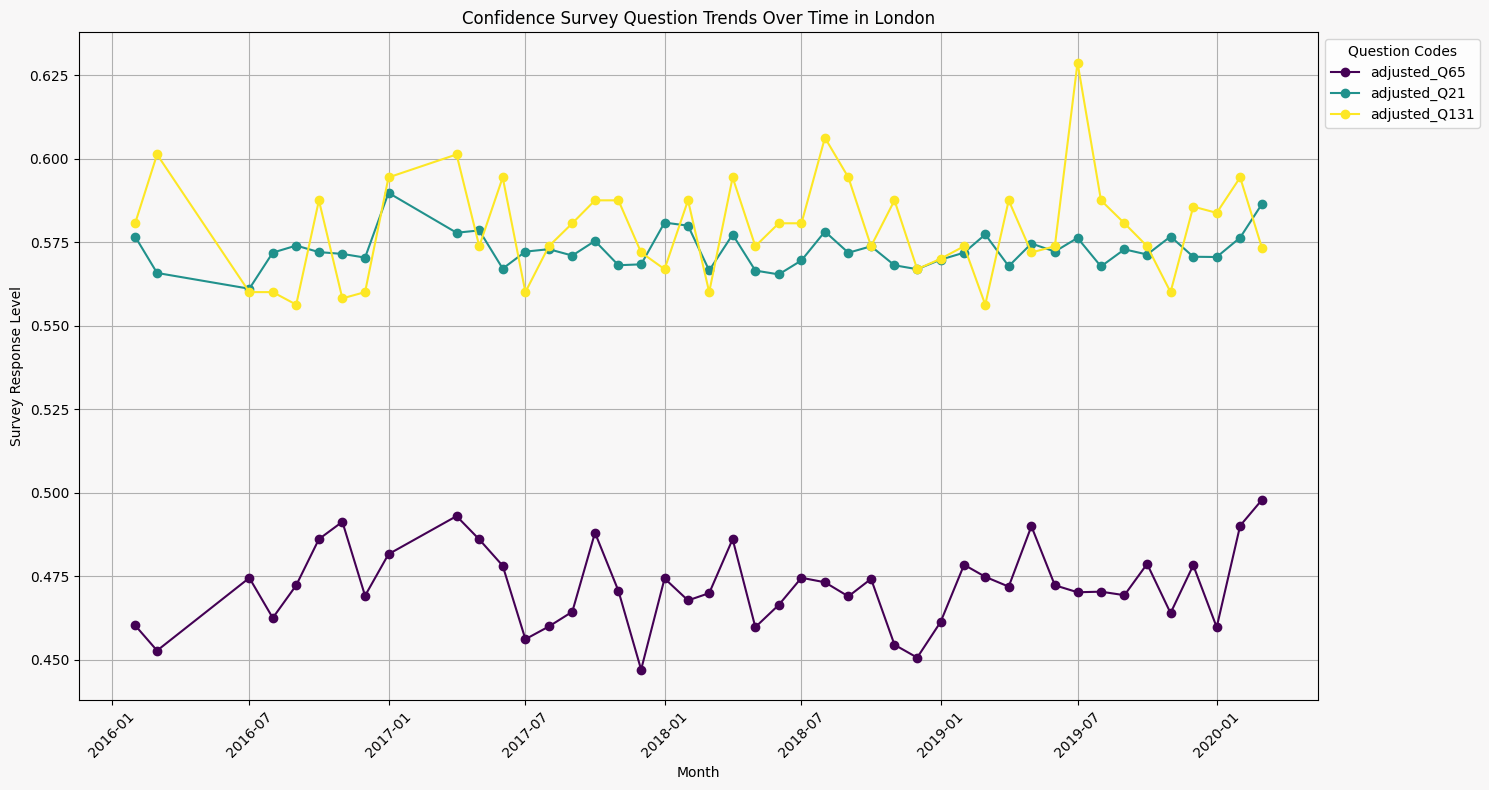

In [112]:
london_data = final_grouped.groupby('MONTH').agg({
    'Trust': 'mean',
    'Confidence': 'mean',
    'adjusted_Q79I': 'mean',
    'adjusted_Q79B': 'mean',
    'adjusted_Q79D': 'mean',
    'adjusted_Q79E': 'mean',
    'adjusted_Q62B': 'mean',
    'adjusted_Q62C': 'mean',
    'adjusted_A121': 'mean',
    'adjusted_NQ135BH': 'mean',
    'adjusted_Q65': 'mean',
    'adjusted_Q21': 'mean',
    'adjusted_Q131': 'mean'
}).reset_index()

effectiveness_questions = ['adjusted_Q79I', 'adjusted_Q79B', 'adjusted_Q79D', 'adjusted_Q79E']
fairness_engagement_questions = ['adjusted_Q62B', 'adjusted_Q62C', 'adjusted_A121']
accountability_questions = ['adjusted_NQ135BH']
confidence_questions = ['adjusted_Q65', 'adjusted_Q21', 'adjusted_Q131']

plt.rcParams['figure.facecolor'] = '#f8f7f7'

def plot_category(data, questions, category_name):
    plt.figure(figsize=(15, 8), facecolor='#f8f7f7')
    colors = plt.cm.viridis(np.linspace(0, 1, len(questions)))
    for i, col in enumerate(questions):
        plt.plot(data['MONTH'], data[col], label=col, color=colors[i], marker='o', linestyle='-')
    plt.title(f'{category_name} Survey Question Trends Over Time in London')
    plt.xlabel('Month')
    plt.ylabel('Survey Response Level')
    plt.legend(title='Question Codes', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.gca().set_facecolor('#f8f7f7')
    plt.tight_layout()
    plt.show()

# Plot each category
plot_category(london_data, effectiveness_questions, 'Effectiveness')
plot_category(london_data, fairness_engagement_questions, 'Fairness and Engagement')
plot_category(london_data, accountability_questions, 'Accountability')
plot_category(london_data, confidence_questions, 'Confidence')

In [113]:
PAS_file_path = "data/PAS_T&Cdashboard_to Q3 23-24.xlsx"
df_PAS = pd.read_excel(PAS_file_path, sheet_name='Borough')

trust_data = df_PAS[df_PAS['Measure'] == 'Trust MPS']

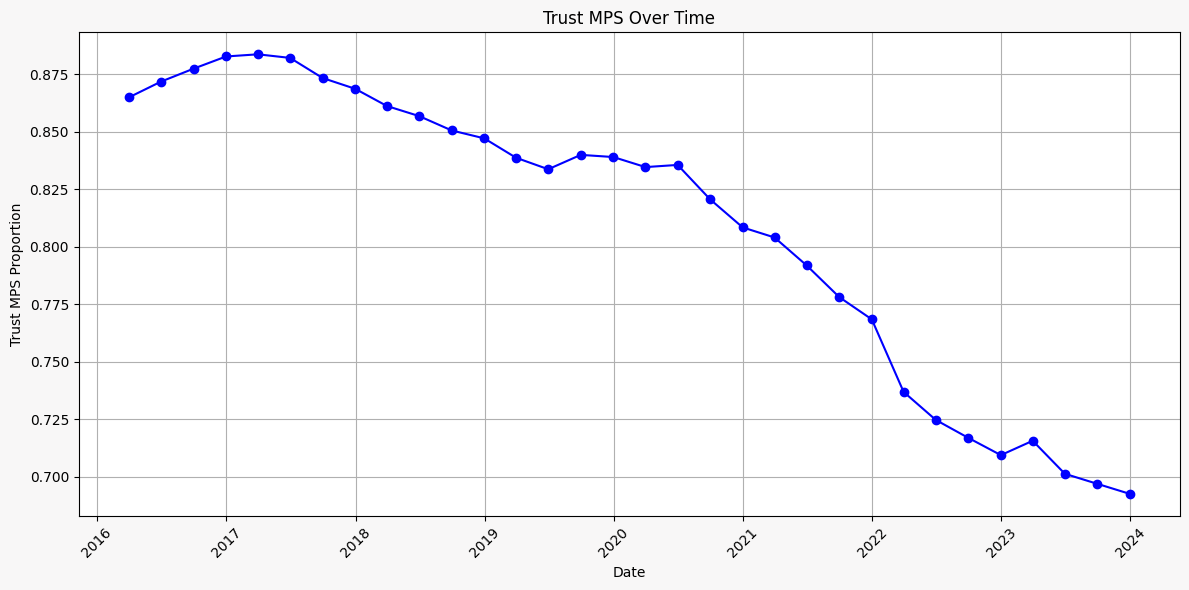

In [114]:
trust_mps_over_time = trust_data.groupby('Date')['Proportion'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(trust_mps_over_time['Date'], trust_mps_over_time['Proportion'], marker='o', linestyle='-', color='blue')
plt.title('Trust MPS Over Time')
plt.xlabel('Date')
plt.ylabel('Trust MPS Proportion')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

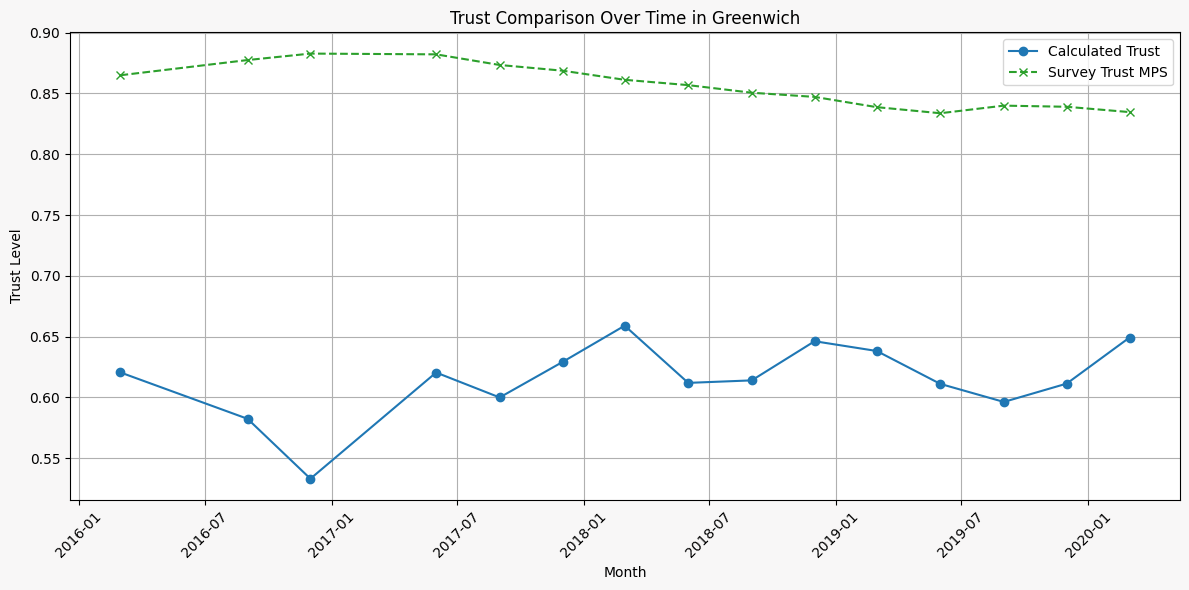

In [115]:
trust_mps_over_time['Date'] = pd.to_datetime(trust_mps_over_time['Date'], dayfirst=True)

# Change the Date to the start of the month to match with 'MONTH' in final_grouped
trust_mps_over_time['Month'] = trust_mps_over_time['Date'].dt.to_period('M').dt.to_timestamp()

combined_data_trust = pd.merge(borough_data, trust_mps_over_time[['Month', 'Proportion']], left_on='MONTH', right_on='Month', how='inner')

# Rename
combined_data_trust.rename(columns={'Proportion': 'Trust MPS'}, inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(combined_data_trust['MONTH'], combined_data_trust['Trust'], color='tab:blue', marker='o', linestyle='-', label='Calculated Trust')
plt.plot(combined_data_trust['MONTH'], combined_data_trust['Trust MPS'], color='tab:green', marker='x', linestyle='--', label='Survey Trust MPS')
plt.title('Trust Comparison Over Time in Greenwich')
plt.xlabel('Month')
plt.ylabel('Trust Level')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [116]:
# Calculate correlation
correlation = combined_data_trust[['Trust', 'Confidence']].corr()
print("Correlation between Calculated Trust and Trust MPS:")
print(correlation)

Correlation between Calculated Trust and Trust MPS:
               Trust  Confidence
Trust       1.000000    0.814304
Confidence  0.814304    1.000000


In [117]:
# Calculate correlation
correlation = combined_data_trust[['Trust', 'Trust MPS']].corr()
print("Correlation between Calculated Trust and Trust MPS:")
print(correlation)

Correlation between Calculated Trust and Trust MPS:
              Trust  Trust MPS
Trust      1.000000  -0.462922
Trust MPS -0.462922   1.000000


### Correlation of determinants of trust and confidence against Trust MPS

In [118]:
effectiveness = grouped.groupby('Date').mean()[['Effectiveness']]
fairness_engagement = grouped.groupby('Date').mean()[['Fairness and Engagement']]
accountability = grouped.groupby('Date').mean()[['Accountability']]
trust = grouped.groupby('Date').mean()[['Trust']]

plt.plot(trust_mps_over_time[trust_mps_over_time['Date'] < '2021']['Date'],trust_mps_over_time[trust_mps_over_time['Date'] < '2021']['Proportion']  , label = "Trust MPS")
plt.plot(effectiveness.reset_index()['Date'], effectiveness.reset_index()['Effectiveness'], label='Effectiveness')
plt.plot(fairness_engagement.reset_index()['Date'], fairness_engagement.reset_index()['Fairness and Engagement'], label='Fairness and Engagement')
plt.plot(accountability.reset_index()['Date'], accountability.reset_index()['Accountability'], label='Accountability')
plt.plot(trust.reset_index()['Date'], trust.reset_index()['Trust'], label='trust')

plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

TypeError: Could not convert Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016Feb 2016 to numeric

### Correlation of Amount of unsuccesfully tackled outcomes and Trust/Confidence

In [119]:
file_path = 'C:/Users/20220678/Microsoft VS Code/JBG050-DC2-Grp21/data/course_crimes_outcomes/course_crimes_outcomes.csv'

# Load the outcomes data
outcome_df = pd.read_csv(file_path)

In [120]:
print(outcome_df['Outcome type'].unique())

['Suspect charged' 'Offender sent to prison'
 'Investigation complete; no suspect identified' nan
 'Offender given a caution' 'Defendant found not guilty'
 'Offender given a drugs possession warning'
 'Offender given suspended prison sentence'
 'Offender given community sentence' 'Offender given penalty notice'
 'Local resolution' 'Offender deprived of property' 'Offender fined'
 'Court case unable to proceed' 'Offender otherwise dealt with'
 'Formal action is not in the public interest'
 'Offender given conditional discharge'
 'Offender ordered to pay compensation'
 'Suspect charged as part of another case'
 'Offender given absolute discharge' 'Defendant sent to Crown Court'
 'Unable to prosecute suspect']


In [121]:
def categorize_outcome(outcome):
    successful_outcomes = [
        'Suspect charged', 'Offender given a drugs possession warning',
        'Local resolution', 'Offender given a caution',
        'Offender given penalty notice', 'Suspect charged as part of another case',
        'Offender fined', 'Offender given community sentence',
        'Offender given suspended prison sentence',
        'Offender sent to prison', 'Offender given conditional discharge',
        'Offender otherwise dealt with', 'Offender ordered to pay compensation',
        'Offender deprived of property', 'Defendant found not guilty',
        'Offender given absolute discharge', 'Defendant sent to Crown Court'
    ]
    unsuccessful_outcomes = [
        'Investigation complete; no suspect identified', 
        'Formal action is not in the public interest',
        'Unable to prosecute suspect',
        'Court case unable to proceed', np.nan
    ]
    
    if outcome in successful_outcomes:
        return "Successful"
    elif outcome in unsuccessful_outcomes:
        return "Unsuccessful"
    else:
        return "Other"

outcome_df['Intervention_Success'] = outcome_df['Outcome type'].apply(categorize_outcome)

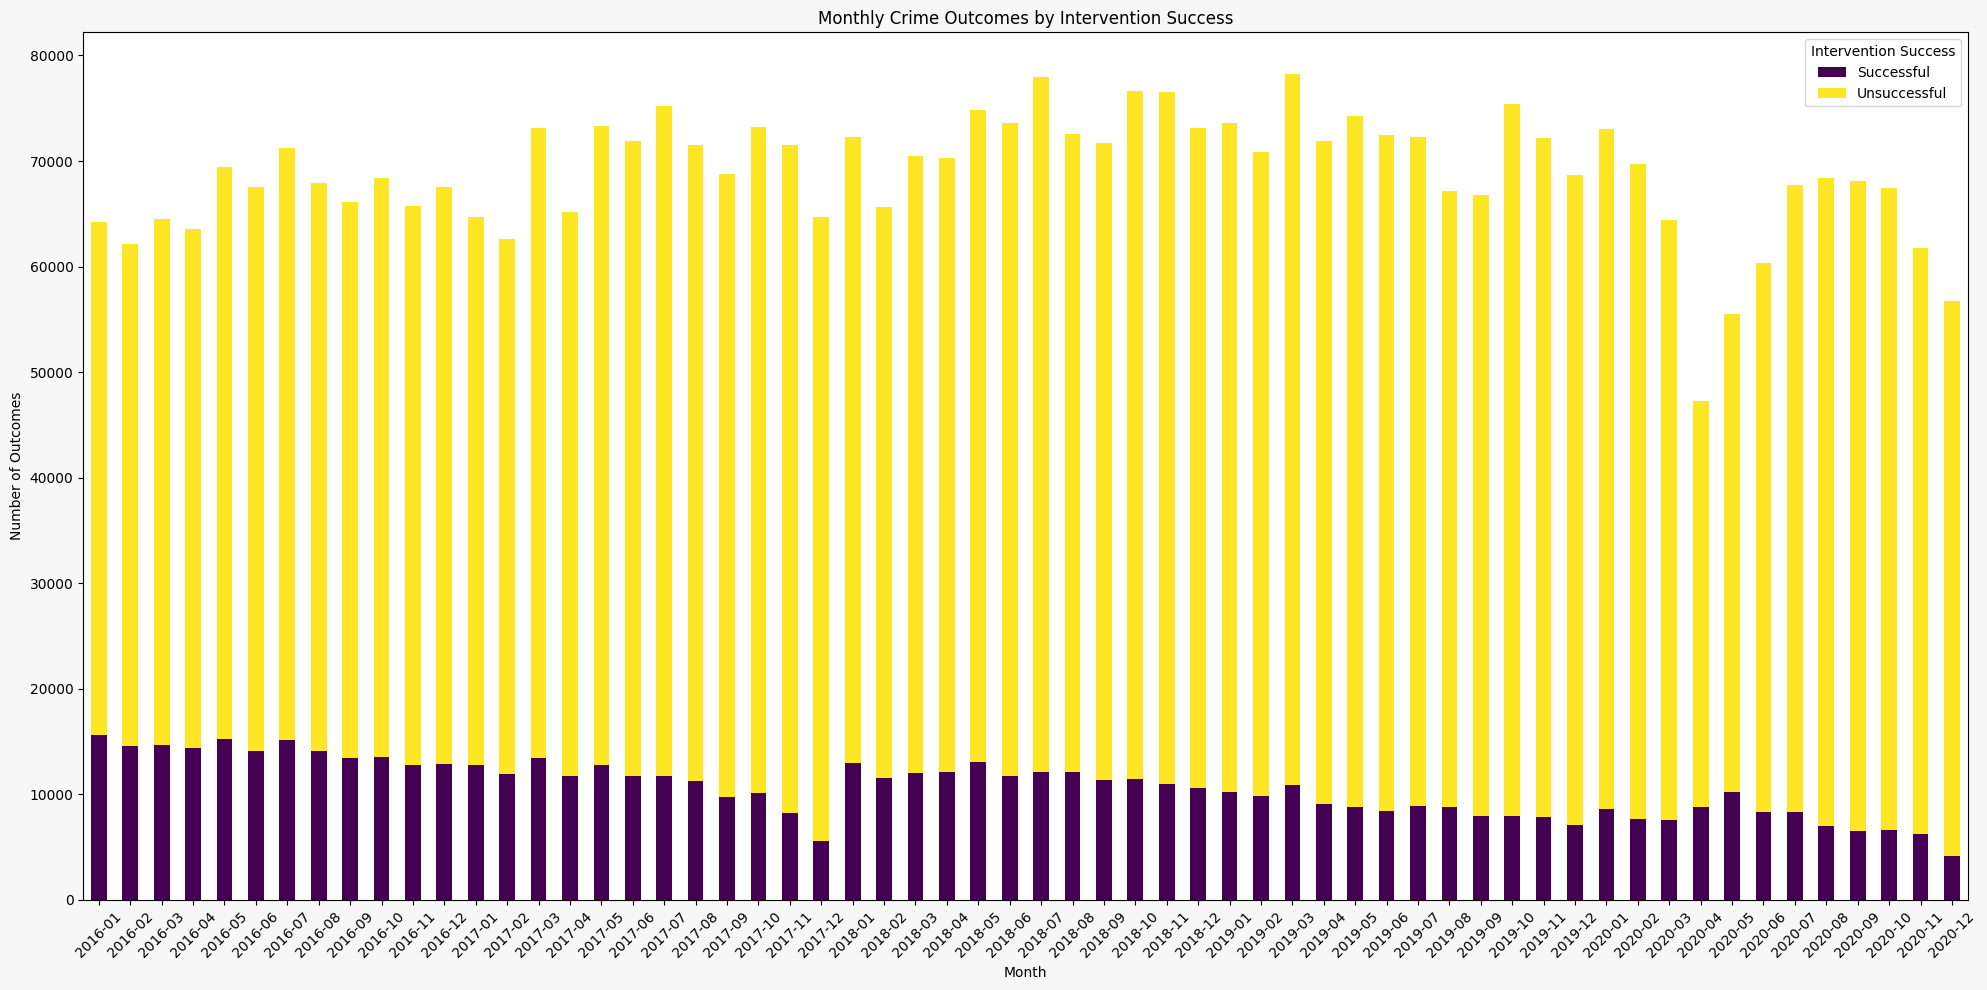

In [122]:
monthly_outcomes = outcome_df.groupby(['Month', 'Intervention_Success']).size().unstack(fill_value=0)

monthly_outcomes.plot(kind='bar', stacked=True, figsize=(20, 10), colormap='viridis')
plt.title('Monthly Crime Outcomes by Intervention Success')
plt.xlabel('Month')
plt.ylabel('Number of Outcomes')
plt.xticks(rotation=45)
plt.legend(title='Intervention Success')
plt.tight_layout()
plt.show()

In [123]:
monthly_success_rate = monthly_outcomes.apply(lambda x: x['Successful'] / x.sum(), axis=1)

success_rate_df = pd.DataFrame({
    'Month': monthly_success_rate.index,
    'Success Rate': monthly_success_rate.values
})

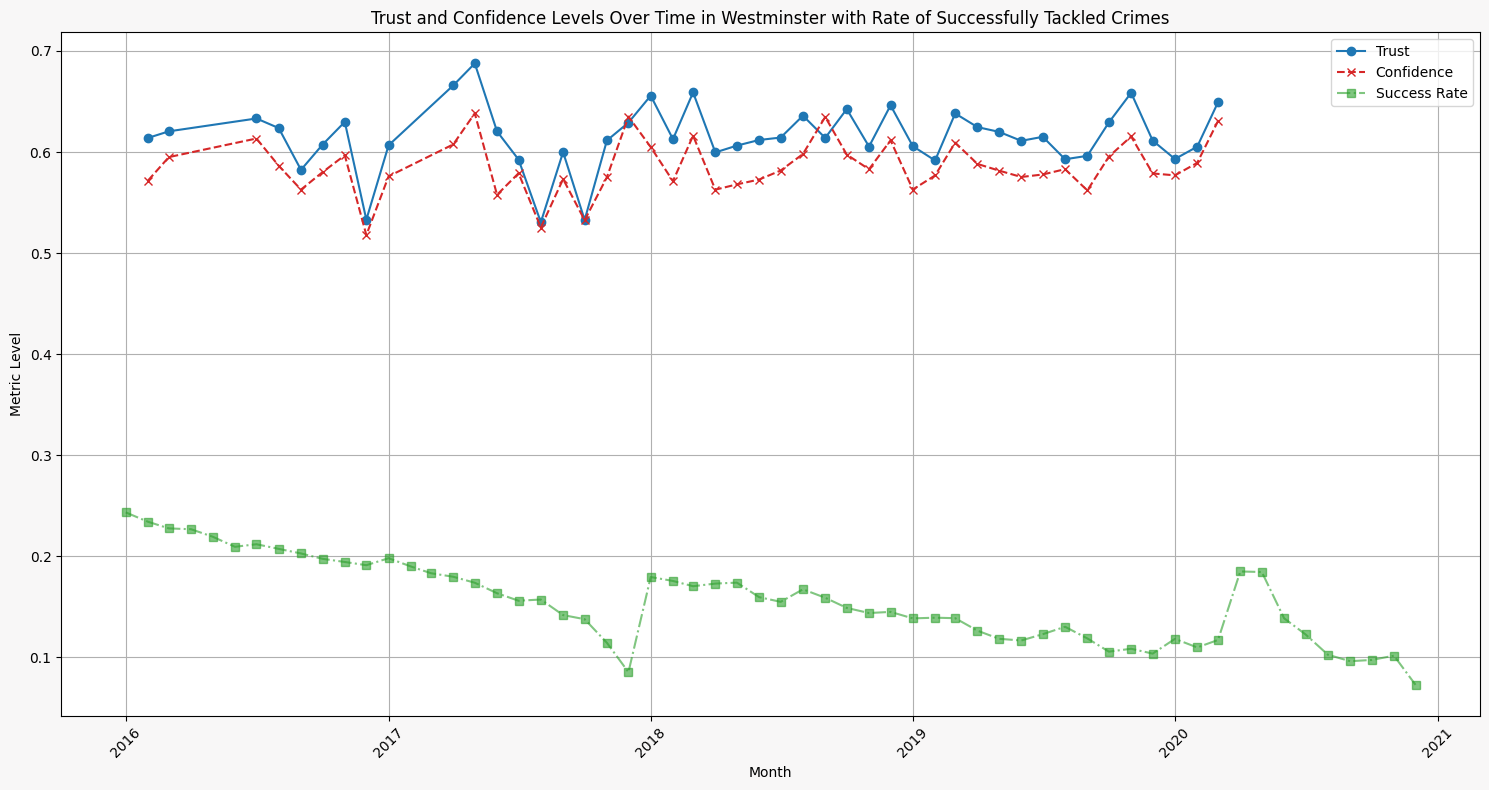

In [124]:
borough_data['MONTH'] = pd.to_datetime(borough_data['MONTH'])
success_rate_df['Month'] = pd.to_datetime(success_rate_df['Month'])

plt.figure(figsize=(15, 8))

plt.plot(borough_data['MONTH'], borough_data['Trust'], color='tab:blue', marker='o', linestyle='-', label='Trust')
plt.plot(borough_data['MONTH'], borough_data['Confidence'], color='tab:red', marker='x', linestyle='--', label='Confidence')
plt.plot(success_rate_df['Month'], success_rate_df['Success Rate'], color='tab:green', marker='s', linestyle='-.', label='Success Rate', alpha=0.6)

plt.title('Trust and Confidence Levels Over Time in Westminster with Rate of Successfully Tackled Crimes')
plt.xlabel('Month')
plt.ylabel('Metric Level')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [125]:
borough_data['MONTH'] = pd.to_datetime(borough_data['MONTH']).dt.to_period('M').dt.to_timestamp()
success_rate_df['Month'] = pd.to_datetime(success_rate_df['Month']).dt.to_period('M').dt.to_timestamp()

combined_data = pd.merge(borough_data, success_rate_df, left_on='MONTH', right_on='Month', how='inner')

combined_data.rename(columns={'Success Rate': 'Success_Rate'}, inplace=True)

correlation_matrix = combined_data[['Trust', 'Confidence', 'Success_Rate']].corr()

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                 Trust  Confidence  Success_Rate
Trust         1.000000    0.855834     -0.001215
Confidence    0.855834    1.000000     -0.114925
Success_Rate -0.001215   -0.114925      1.000000
